# Advanced Modeling

### Problem Statement

**How can we reduce waste based on historical data of the restaurant to increase or maximize profits?**

A challenge a local Miami restaurant is facing pertains to the cost of waste associated with their menu items. There are a variety of factors that might influence the performance of a restaurant daily. With that said, the main question becomes: how can we reduce waste based on historical data of the restaurant to increase or maximize profits? My project intends to address the number of slices the restaurant should produce in order to minimize waste. This includes exploring the relationships between the amount of slices that were sold and other factors that the owners believe could impact the demand at certain points throughout the year. This notebook will explore the more complex models like Auto Arima, Prophet, and a LSTM Neural Network in an attempt to accurately model customer demand. 

In [1]:
# importing libraries 

import numpy as np
import pandas as pd

# plotting 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# timeseries train test split and metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

Before we get into the more complex models, we need to load our preprocessed data and make sure that we are using the cleaned and preprocessed data.

In [2]:
# loading data
slice_data = pd.read_csv('slice_data_preprocesed.csv')

In [3]:
slice_data["Date"] = pd.to_datetime(slice_data["Date"])  # making sure the date is a date time object 
slice_data = slice_data.set_index("Date") # for time series we need to make our index to be the date

slice_data.head() # look at the first five rows of the data set

,Sold (Qty),Produced (Qty),Temperature (Avg.),Rain?,Waste (%),Waste (Qty),Revenue/ Profit,Season,Cheese,Napolitana,Pepperoni,Primavera,Vegetariana
Date,,,,,,,,,,,,,
2023-01-01,120,124,77.5,0,0.03,4,720,2,0,0,1,0,0
2023-01-01,105,106,77.5,0,0.01,1,630,2,1,0,0,0,0
2023-01-01,120,126,77.5,0,0.05,6,840,2,0,0,0,0,1
2023-01-01,60,61,77.5,0,0.01,1,420,2,0,0,0,1,0
2023-01-01,45,46,77.5,0,0.02,1,315,2,0,1,0,0,0


Now, our next step is to resample our data. Since we have data for a year, it is sensible to resample our data on a daily basis. We can do so by using the **.resample()** method containing the **"D"** argument which specifies that we want a daily resample. In addition, the **.sum()** mehtod at the end ensures that we are getting the daily totals for each column. Once, we have resampled our data we can split the data into training and testing sets for our advanced models. 

In [4]:
# the "D" option specifies daily frequency by start date
slice_data_daily = slice_data.resample("D").sum(numeric_only=True)
slice_data_daily[['Sold (Qty)']]

,Sold (Qty)
Date,
2023-01-01,450
2023-01-02,315
2023-01-03,345
2023-01-04,435
2023-01-05,405
...,...
2023-12-27,345
2023-12-28,480
2023-12-29,675


In [5]:
tscv = TimeSeriesSplit(n_splits=3) # splitting data into test and train set

### AutoArima

For our first advanced model we will be looking at the AutoArima model. This model will go through different combinations of the p,d,q and P, D, Q values to identify the best combination of values for the data. Once the values are identified, it will use those values for forecasting purposes. In this case, those values will be used to model customer demand.

In [6]:
from pmdarima import auto_arima

In [7]:
predictions = []
actuals = []
mae_list = []
mse_list = []

for train_index, test_index in tscv.split(slice_data_daily):
    train, test = slice_data_daily.iloc[train_index], slice_data_daily.iloc[test_index]
    
    # Initialize and fit the model 
    auto_arima_model = auto_arima(train['Sold (Qty)'], 
                                  start_p=0, 
                                  d=None, 
                                  start_q=0, 
                                  max_p=8, 
                                  max_d=1, 
                                  max_q=8, 
                                  start_P=0, 
                                  D=None, 
                                  start_Q=0, 
                                  max_P=8, 
                                  max_D=1, 
                                  max_Q=8, 
                                  max_order=8, 
                                  m=7,  # Weekly seasonality for daily data
                                  seasonal=True, 
                                  stationary=False, 
                                  disp=False)  
    
    # Forecasting for the test set
    forecast = auto_arima_model.predict(n_periods=len(test))
    
    # Store forecast and actual values for comparison
    predictions.append(forecast)
    actuals.append(test['Sold (Qty)'].values)
    
    # Evaluate model performance
    mae = mean_absolute_error(test['Sold (Qty)'], forecast)
    mse = mean_squared_error(test['Sold (Qty)'], forecast)
    
    mae_list.append(mae)
    mse_list.append(mse)

In [8]:
print("ARIMA order (p, d, q):", auto_arima_model.order)
print("Seasonal order (P, D, Q, m):", auto_arima_model.seasonal_order)

ARIMA order (p, d, q): (1, 1, 0)
Seasonal order (P, D, Q, m): (3, 0, 0, 7)


Takeaways: 
- p = 1 means that it uses the previous value to predict the current one.  
- d = 1 means that the data was differenced only once to make it stationary. 
- q = 0 means that there is no moving average component. 
- P = 3 means that we included three seasonal autoregressive terms. 
- D = 0 means no seasonal differencing. 
- Q = 0  means no seasonal moving average component. 
- m = 7 means weekly seasonality 

In [9]:
for i, (mae, mse) in enumerate(zip(mae_list, mse_list), start=1):
    print(f"Fold {i}: MAE = {mae:.2f}, MSE = {mse:.2f}")

Fold 1: MAE = 621.17, MSE = 420912.19
Fold 2: MAE = 117.66, MSE = 22283.05
Fold 3: MAE = 250.71, MSE = 86029.75


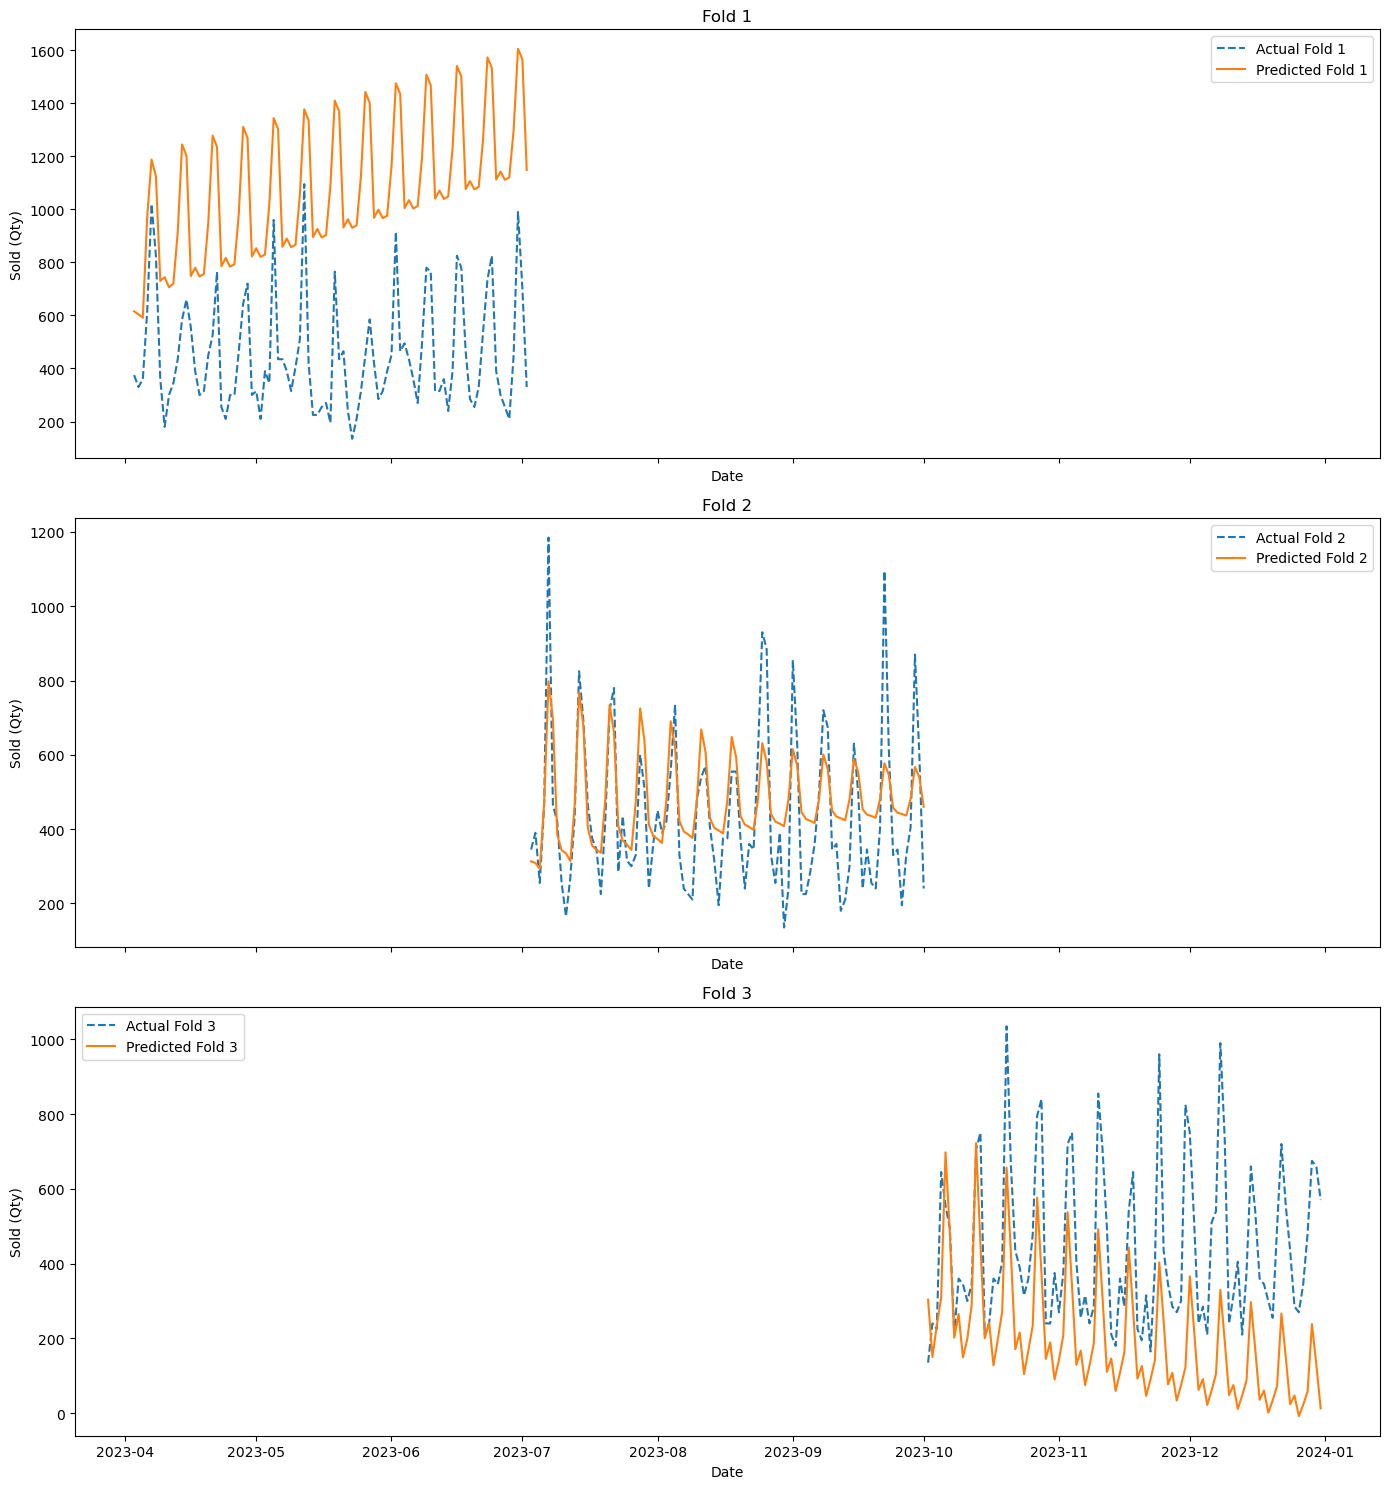

In [10]:
fig, axs = plt.subplots(nrows=len(predictions), ncols=1, figsize=(14, 5 * len(predictions)), sharex=True)

for i, (pred, act, test) in enumerate(zip(predictions, actuals, [slice_data_daily.iloc[test_idx] for _, test_idx in tscv.split(slice_data_daily)]), start=1):
    ax = axs[i - 1]
    7
    ax.plot(test.index, act, label=f'Actual Fold {i}', linestyle='--')
    ax.plot(test.index, pred, label=f'Predicted Fold {i}')
    
    ax.set_title(f'Fold {i}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sold (Qty)')
    ax.legend()

plt.tight_layout()
plt.show()

Takeaways: 
- The first fold used on the the model has a high MAE and MSE, indicating it might not be performing as well on this subset of the data. This could be due to higher variability or a different pattern in the time series during this period. This is further evidenced by the incongruencies between the predicted fold and the actual fold in the visual above. In addtion, it has a worst MAE and MSE in comparison to our baseline SARIMAX model. 
- The second fold used on the model performs significantly better, with a much lower MAE and MSE, suggesting the model fits this subset better. This is further evidenced by the how close the actual values and predicted values are in the visual above. The outcome of the second fold is similar to our baseline model but performs slightly worse in this fold. 
- The third fold's performance lies between the other two folds, showing moderate MAE and MSE. As shown in the in the visual above, most parts of the predicted values are very different than the actual values while also showing a decreasing trend in this fold. This model also does worse on this fold in comparison to our baseline SARIMAX model. 

### Prophet

The next model we will be looking at is Meta's prophet. It is a more powerful model than the previously explored models which is why we will explore how this model performs with our dataset. The model has different parameters that are very explicit with respect to their name, however, we also have some arguments that are not as straight forward like **seasonality_prior_scale** which will be used in our model to target the noise that we encountered previously in our data.

In [11]:
from prophet import Prophet

Before building the prophet model to our use case, we need to rename the columns of our resampled data using the **.rename()** method. This is because Prophet expects the data to be in a specific format: a dataframe with two columns, ds and y for the dates and observations. 

In [12]:
slice_data_daily = slice_data_daily.reset_index()
slice_data_daily = slice_data_daily.rename(columns={'Date': 'ds', 'Sold (Qty)': 'y'})

In [13]:
predictions = []
actuals = []
mae_list = []

for train_index, test_index in tscv.split(slice_data_daily):
    train, test = slice_data_daily.iloc[train_index], slice_data_daily.iloc[test_index]
    
    # Initialize and fit the model
    prophet_model = Prophet(weekly_seasonality = True, # adds seasonality component
                            seasonality_mode = 'multiplicative',
                            seasonality_prior_scale = 0.5) # handles the noise in the data 
    prophet_model.fit(train)
    
    # forcasting
    forecast = prophet_model.predict(test[['ds']])
    
    # Store predictions and actual values
    predictions.append(forecast[['ds', 'yhat']].set_index('ds'))
    actuals.append(test.set_index('ds')['y'])
    
    # Evaluate model performance
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(test['y'], forecast['yhat'])
    mae_list.append(mae)

# Output MAE for each fold
for i, mae in enumerate(mae_list, start=1):
    print(f'Fold {i} MAE: {mae}')

00:31:04 - cmdstanpy - INFO - Chain [1] start processing
00:31:04 - cmdstanpy - INFO - Chain [1] done processing
00:31:04 - cmdstanpy - INFO - Chain [1] start processing
00:31:04 - cmdstanpy - INFO - Chain [1] done processing
00:31:04 - cmdstanpy - INFO - Chain [1] start processing
00:31:04 - cmdstanpy - INFO - Chain [1] done processing


Fold 1 MAE: 379.815984330123
Fold 2 MAE: 95.24102750314327
Fold 3 MAE: 96.92253027197438


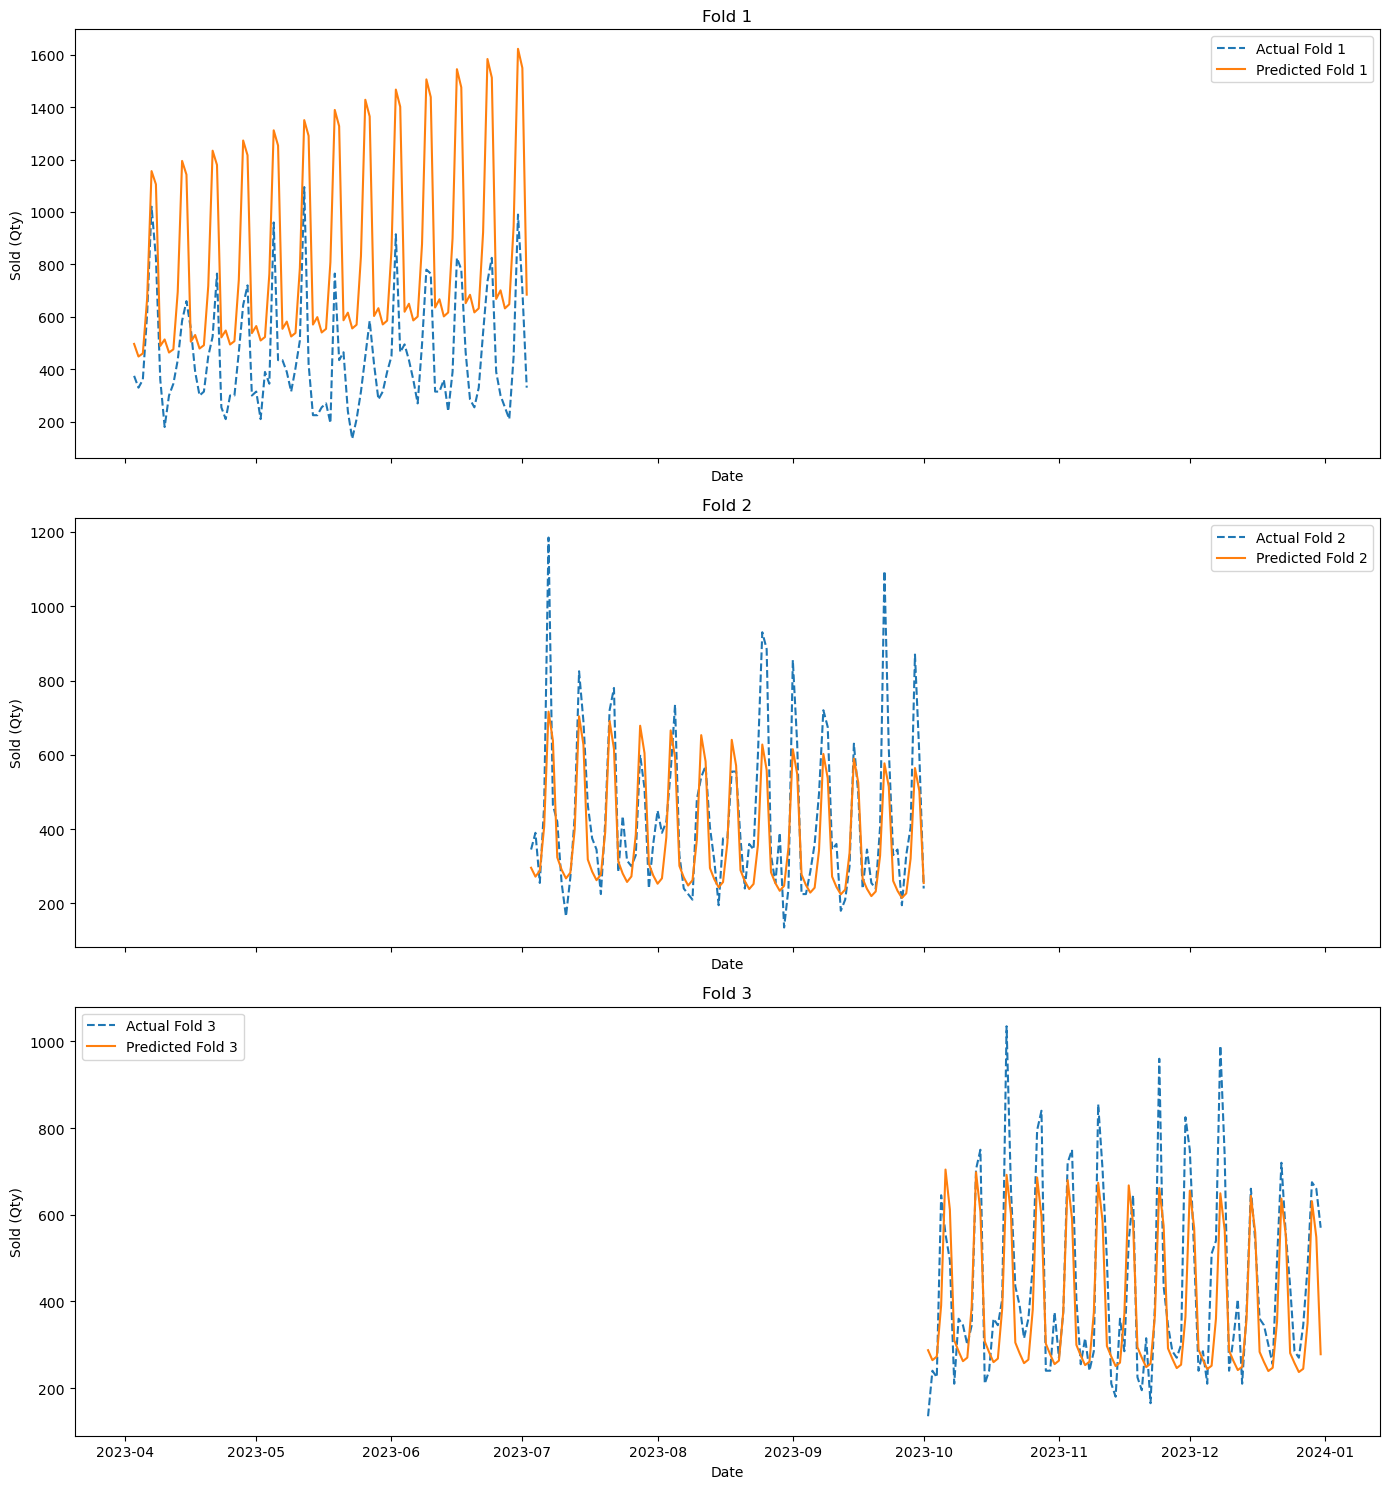

In [14]:
fig, axs = plt.subplots(nrows=len(predictions), ncols=1, figsize=(14, 5 * len(predictions)), sharex=True)

for i, (pred, act) in enumerate(zip(predictions, actuals), start=1):
    ax = axs[i - 1]
    
    ax.plot(act.index, act, label=f'Actual Fold {i}', linestyle='--')
    ax.plot(pred.index, pred['yhat'], label=f'Predicted Fold {i}')
    
    ax.set_title(f'Fold {i}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sold (Qty)')
    ax.legend()

plt.tight_layout()
plt.show()

Takeaways: 
- The first fold used on the the model has a high MAE, indicating it might not be performing as well on this subset of the data. This could be due to higher variability or a different pattern in the time series during this period. This is further evidenced by the incongruencies between the predicted fold and the actual fold in the visual above. However, it is performing slightly better than the baseline SARIMAX model but way better than the AutoArima model. 
- The second fold used on the model performs significantly better, with a much lower MAE, suggesting the model fits this subset better. This is further evidenced by the how close the actual values and predicted values are in the visual above. When comparing it to the baseline model, it does slightly worse. But, it does way better than the AutoArima model. 
- The third fold's performance lies between the other two folds, showing moderate MAE slightly higher than the second fold. As shown in the in the visual above, the predicted values are closer to the the actual values. When comparing it to the baseline SARIMAX and AutoArima model, Prophet does a lot better with this fold.

### LSTM

The last model we will be exploring is a LSTM neural network. The LSTM neural network is a type of Recurrent Neural Network (RNN) that includes a Long-Short Term Memory unit (LSTM) layer which improve on simple RNNs with advanced long-term memory updates. This allows the model to retain important information from past time steps and avoid issues like vanishing gradients, which occur in regular RNNs. For this reason, we believe that the LSTM neural network should be able to capture complex patterns, including seasonality and trends, without requiring explicit feature engineering like ARIMA models.

In [15]:
#importing libraries for neural network
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Before we build our LSTM neural netework, we need to prepare the data in a way where the data points are a sequence of time steps. We can do so by following the code below:

In [16]:
# scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
slice_data_daily['y_scaled'] = scaler.fit_transform(slice_data_daily[['y']])

# prepare data for LSTM
def lstm_dataset(data, time_step=7):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 7  # lags
data = slice_data_daily[['y_scaled']].values

X, y = lstm_dataset(data, time_step)
X = X.reshape((X.shape[0], X.shape[1], 1))  # reshape for LSTM

In [17]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(LSTM(units=50))
    model.add(Dropout(0.25))
    model.add(Dense(1))  
    model.compile(optimizer='adam', loss='mse')
    return model

In [18]:
mae_list = []

# time series cross-validation loop
for train_index, test_index in tscv.split(slice_data_daily):
    train, test = slice_data_daily.iloc[train_index], slice_data_daily.iloc[test_index]
    
    # normalize and prepare the training and testing datasets
    train_scaled = scaler.transform(train[['y']])
    test_scaled = scaler.transform(test[['y']])
    
    X_train, y_train = lstm_dataset(train_scaled, time_step)
    X_test, y_test = lstm_dataset(test_scaled, time_step)
    
    # reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    

    model = build_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=100, verbose=0)
    
    # predictions
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)

for i, mae in enumerate(mae_list, start=1):
    print(f'Fold {i} MAE: {mae}')

2024-09-20 00:31:16.424212: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 0s 2ms/step
Fold 1 MAE: 127.66081369659047
Fold 2 MAE: 120.70431424364631
Fold 3 MAE: 103.59869874553915


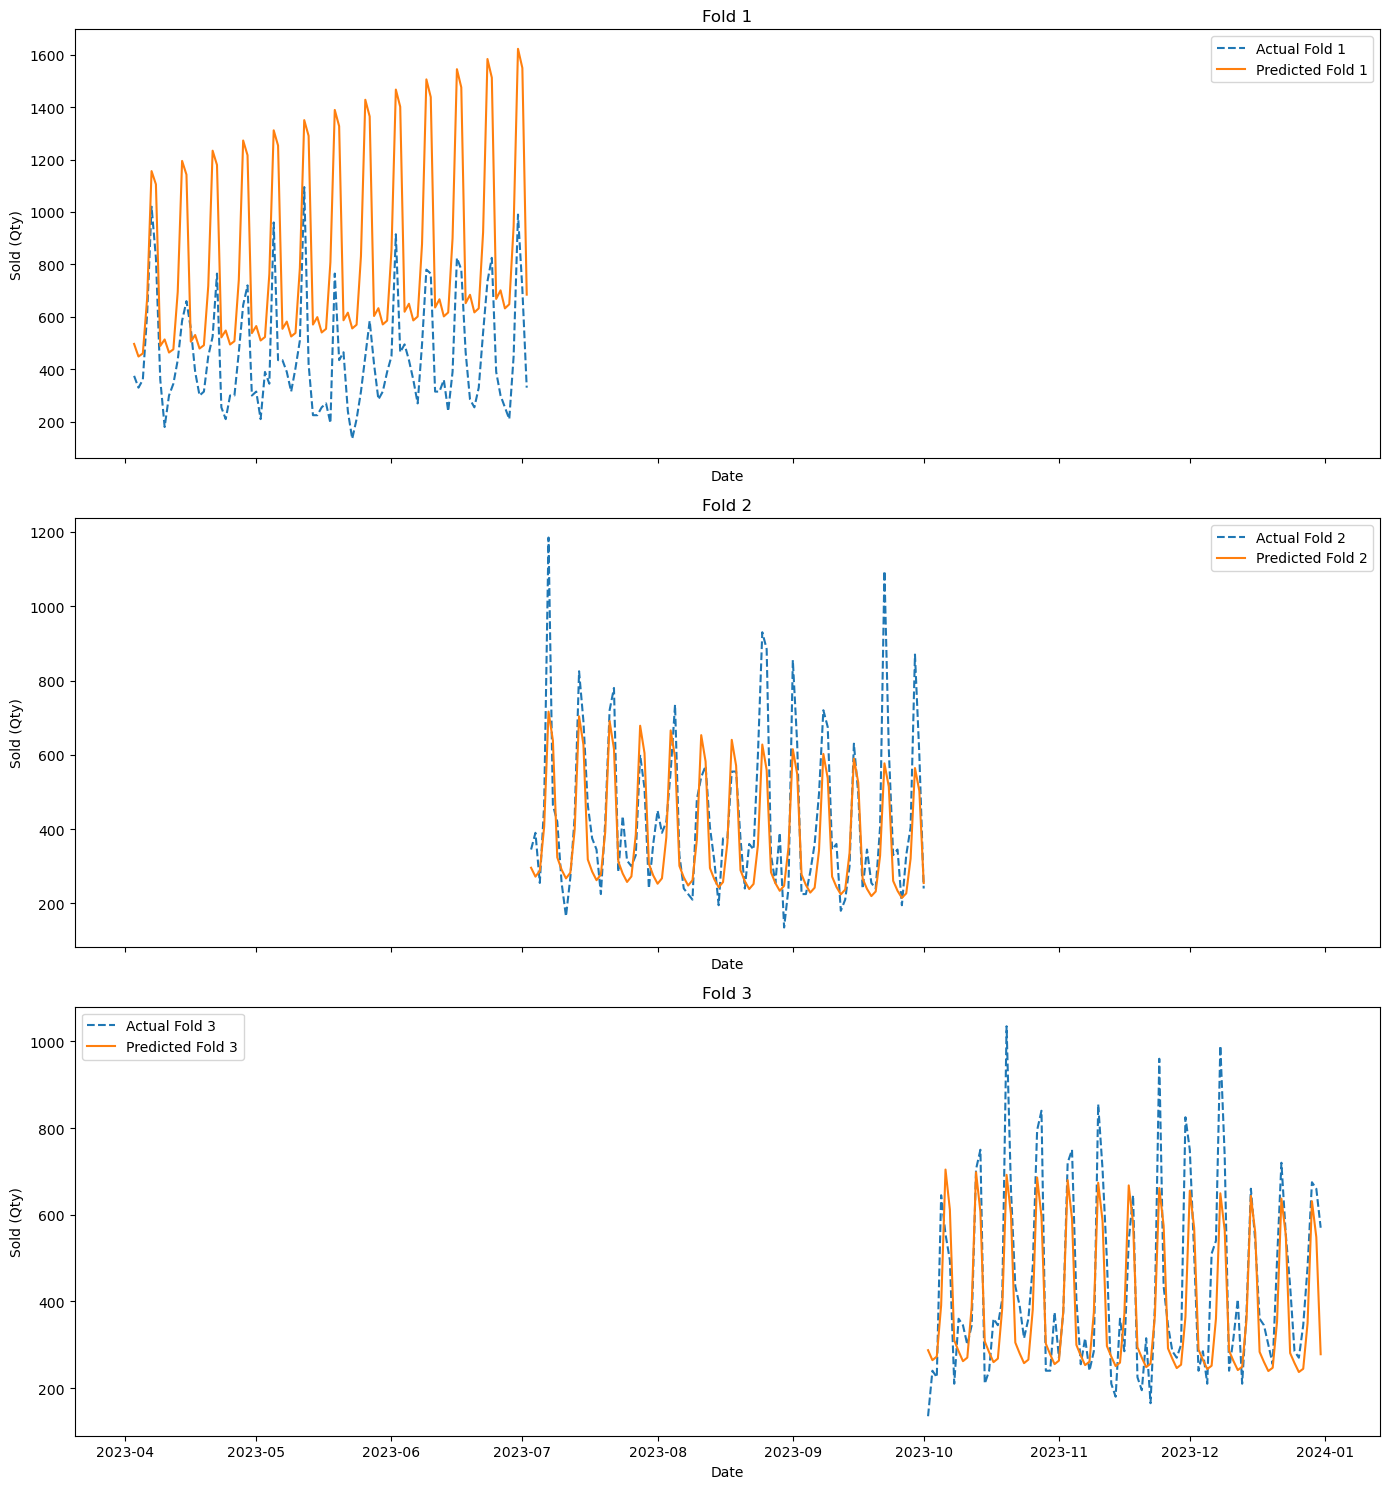

In [19]:
fig, axs = plt.subplots(nrows=len(predictions), ncols=1, figsize=(14, 5 * len(predictions)), sharex=True)

for i, (pred, act) in enumerate(zip(predictions, actuals), start=1):
    ax = axs[i - 1]
    ax.plot(act.index, act, label=f'Actual Fold {i}', linestyle='--')
    ax.plot(pred.index, pred, label=f'Predicted Fold {i}')
    ax.set_title(f'Fold {i}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sold (Qty)')
    ax.legend()

plt.tight_layout()
plt.show()

Takeaways: 
- The first fold used on the the model has a highest MAE, indicating it might not be performing as well on this subset of the data. This could be due to higher variability or a different pattern in the time series during this period. This is further evidenced by the incongruencies between the predicted fold and the actual fold in the visual above. However, when comparing it to previous models, it does significantly better than the baseline SARIMAX model, Prophet, and AutoArima.
- The second fold used on the model performs slightly better, with a lower MAE, suggesting the model fits this subset better. This is further evidenced by the how close the actual values and predicted values are in the visual above. When looking at previous models, it does slightly worse as it would have the highest MAE. 
- The third fold's performance lies between the other two fold. As shown in the in the visual above, the model's predicted values are close to the actual values. However, the Prophet model is the only model that beats the LSTM neural network in this fold slightly but does better than the baseline SARIMAX model and the AutoArima model. 

### Conclusion

Now that we have explored other models, we are able to look back at their performance to see which model is the best at predicting customer demand. Our baseline model showed an acceptable understanding of customer demand at the second and third fold but struggled with the first fold. Looping through different combinations might allow for the model to perform better in this regard. When it comes to our Auto Arima model, this model performed the worst and only showed an acceptable understanding of customer demand in the second fold which is something all of our models share. In terms of the Prophet model, it performed better than the aforementioned models but also struggled to capture customer demand on the first fold. Like our baseline model, attempting different combinations might also improve the model's performance within the first fold and also overall. Now, our last model, the LSTM neural network showed a consisten MAE across all folds which makes it our best model despite only outperforming other models in the first fold.